# Инструменты проверки гипотез в Python

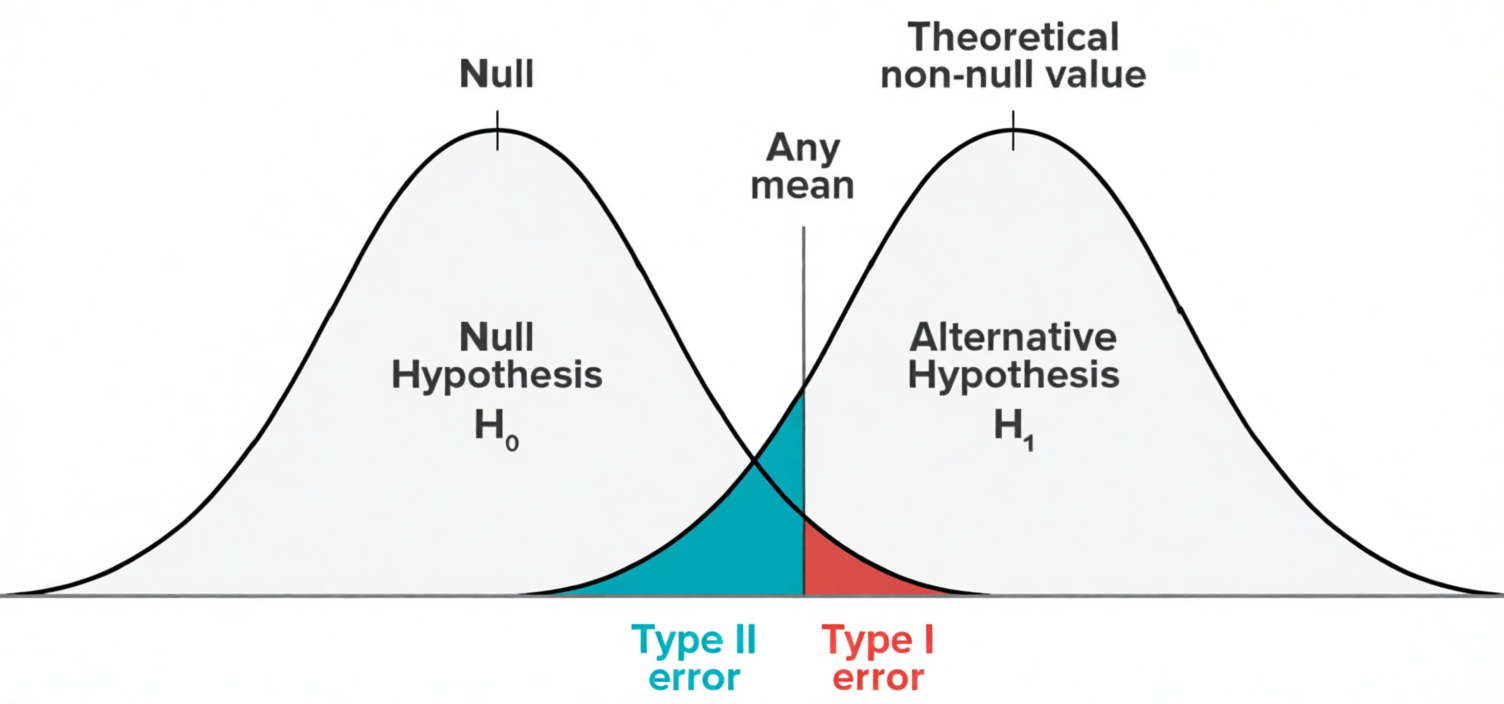

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.style.use('ggplot')
pd.set_option('display.max_colwidth', None)

В статистике выделяют несколько **типов статистических гипотез**:

1. **Гипотеза согласия**: проверить, соответствует ли выборка предполагаемому теоретическому распределению (например, нормальному, равномерному, Пуассона и тд).

2. **Гипотеза однородности**: проверить, одинаково ли распределена одна и та же переменная в разных независимых группах.

3. **Гипотеза независимости**: проверить, существует ли статистическая связь между двумя переменными в одной выборке.

4. **Гипотеза о параметре распределения**: проверить утверждение о конкретном параметре (среднем, дисперсии и тд) в предположении о виде распределения.

# Ошибки I и II рода в задаче кредитного одобрения

Банковский служащий должен принимать решение $-$ выдавать клиенту кредит или отказать. На основе имеющихся данных о клиенте служащий (или автоматизированная система) классифицирует заявку как "одобрить" или "отказать".
<br>

`Гипотезы.` Формально это задача бинарной классификации, в которой:

- *Нулевая гипотеза $H_0$*: клиент **не вернёт** кредит.
- *Альтернативная гипотеза $H_1$*: клиент **вернёт** кредит.

Решение выдать кредит эквивалентно отклонению $H_0$.

`Типы ошибок:`

- *Ошибка I рода* $-$ выдать кредит ненадёжному клиенту.
- *Ошибка II рода* $-$ отказать надёжному (платёжеспособному) клиенту.

`А что если попытаться свести ошибку I рода к нулю?`

Тогда правило принятия решений станет крайне консервативным: кредиты будут одобряться только в самых очевидных случаях, а во всех остальных $-$ следует отказ. В результате надёжным клиентам будет очень часто отказано.

Банк действительно сильно снизит риск потерь, но за счёт упущенной прибыли: большинство потенциально выгодных заемщиков не получат финансирование.

Следовательно, на практике важно найти разумный компромисс между контролем риска дефолта и сохранением возможности получения дохода.

# Гипотеза о нормальности распределения (пример 1)

В дальнейшем анализе используются данные о городах Советского Союза, полученные в ходе всесоюзной переписи населения 1959 года.

**Структура**:
- *номер* — порядковый номер города  
- *город* — название города
- *население* — численность населения в тысячах человек

In [ ]:
data = pd.read_csv('town_1959_2.csv', encoding='cp1251', index_col='номер')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 1 to 1004
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   город      1004 non-null   object 
 1   население  1004 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.5+ KB


In [ ]:
data[:3]

,город,население
номер,,
1,Москва,5046.0
2,Санкт-Петербург,3003.0
3,Нижний_Новгород,941.0


In [ ]:
# Кол-во уникальных городов
data['город'].nunique()

987

In [ ]:
# Дубликаты
data['город'].value_counts().loc[lambda x: x > 1]

,count
город,
Советск,3
Чехов,2
Благовещенск,2
Красноармейск,2
Горнозаводск,2
Троицк,2
Гурьевск,2
Краснослободск,2
Киров,2


In [ ]:
indices_to_drop = [
    616, 776, 802, 672, 666,
    723, 920, 325, 882, 422,
    694, 597, 231, 445, 981, 818, 684
]

data = data.drop(indices_to_drop)
data = data.reset_index(drop=True)

print(f'Кол-во удалённых записей: {len(indices_to_drop)}')

Кол-во удалённых записей: 17


> Лишние записи были исключены на основании ручной проверки и сопоставления с данными из открытых источников.

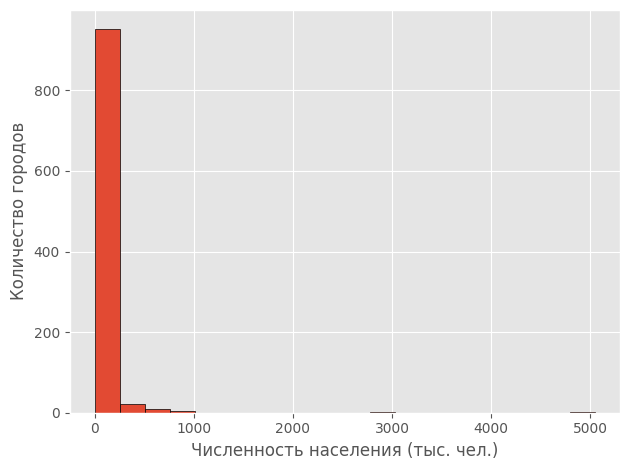

In [ ]:
# Гистограмма
data['население'].hist(bins=20, edgecolor='black')
plt.xlabel('Численность населения (тыс. чел.)')
plt.ylabel('Количество городов')
plt.tight_layout()
plt.show()

> Наблюдается выраженная правосторонняя асимметрия: подавляющее большинство городов $-$ малые или средние, тогда как крупных городов крайне мало.

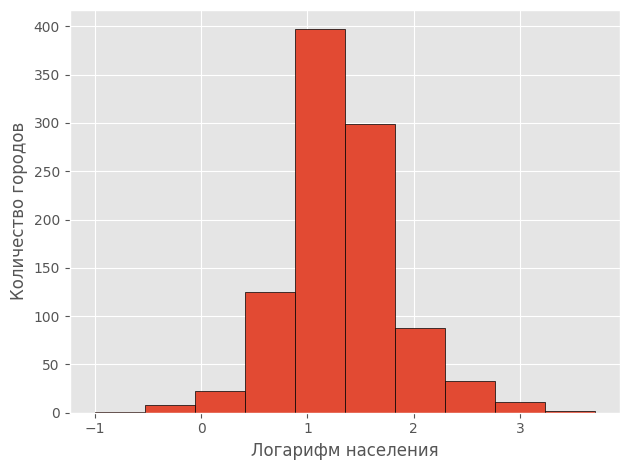

In [ ]:
# log гистограмма
log_pop_size = np.log10(data['население'])
plt.hist(log_pop_size, edgecolor='black')
plt.xlabel('Логарифм населения')
plt.ylabel('Количество городов')
plt.tight_layout()
plt.show()

> Логнормальное распределение?

## Сравнение эмпирического распределения с теоретическим нормальным распределением

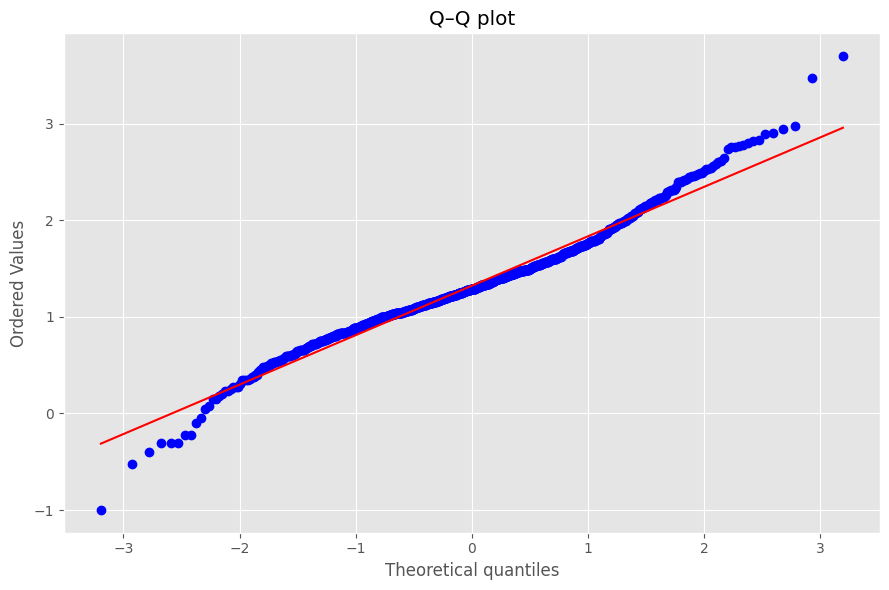

In [ ]:
plt.figure(figsize=(9, 6))
stats.probplot(log_pop_size, dist='norm', plot=plt)
plt.title('Q–Q plot')
plt.tight_layout()
plt.show()

> Видно значительное отклонение от нормального распределения: точки сильно расходятся с теоретической линией, особенно в хвостах.

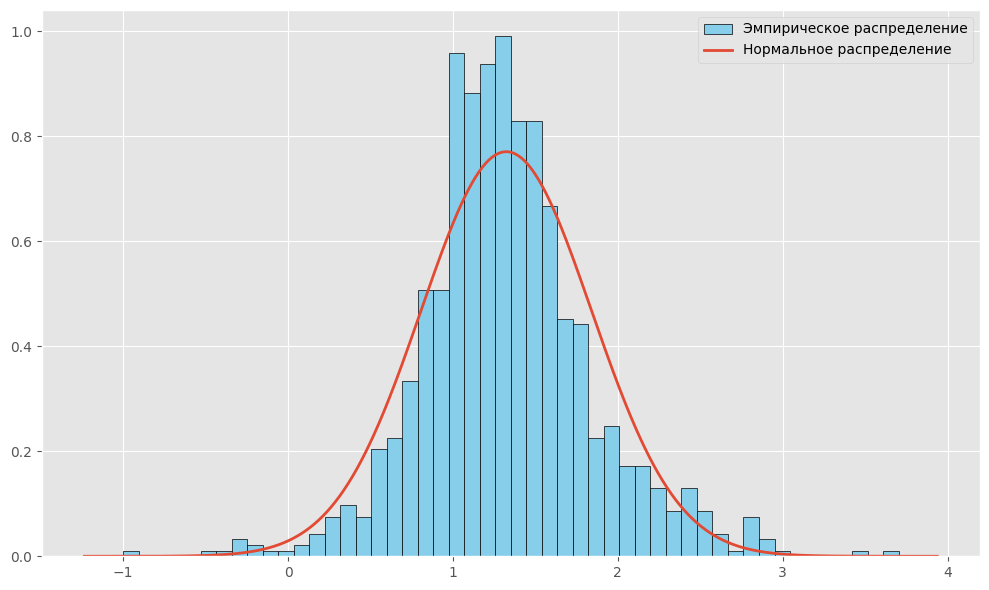

In [ ]:
log_x = log_pop_size
plt.figure(figsize=(10, 6))

# Построение гистограммы с плотностью
plt.hist(log_x, bins=50, density=True,
         color='skyblue', edgecolor='black', label='Эмпирическое распределение'
)

# Подгонка нормального распределения
mu, std = np.mean(log_x), np.std(log_x)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = stats.norm.pdf(x, mu, std)

# Наложение теоретической кривой
plt.plot(x, p, linewidth=2, label='Нормальное распределение')

plt.legend()
plt.tight_layout()
plt.show()

> Эмпирическое распределение имеет тяжёлые хвосты, присутствуют выбросы, нарушена колоколообразность, наблюдается незначительная правосторонняя асимметрия.

## Тест Шапиро–Уилка для проверки нормальности распределения

**Нулевая гипотеза $H_0$**: исходные данные логнормальны

**Альтернативная гипотеза $H_1$**: исходные данные НЕ являются логнормальными

In [ ]:
p_value = stats.shapiro(log_pop_size)[1]
print(f'p-value: {p_value:.3e}')

p-value: 6.257e-12


Полученное значение `p-value` намного меньше стандартных порогов значимости. Следовательно, имеются статистически значимые основания для `отклонения нулевой гипотезы`.

> *В данном случае **p-value** отвечает на вопрос: насколько вероятно получить такие или более экстремальные отклонения от нормального распределения совершенно **случайно**, если нулевая гипотеза верна?*

<br>

Некоторые статистические методы **предполагают нормальность данных**, однако на практике они устойчивы к умеренным отклонениям от этого условия.

Согласно общепринятому подходу, **необходимо**:

- **Строго** относиться к присутствию выбросов
- **Снисходительно** $-$ к умеренным отклонениям от симметрии
- **Снисходительно** $-$ к умеренным отклонениям от колоколообразной формы

<br>

`Выводы:`

- Несмотря на формальное отклонение от нормальности, мы можем снисходительно отнестись к умеренным отклонениям формы и симметрии.
- Выбросы следует обработать.
- При этом распределение приближённо напоминает логнормальное и может быть использовано как рабочая модель для практических целей.

# Гипотеза о нормальности распределения (пример 2)

Данные, с которыми будем работать далее, представляют собой ежемесячную статистику по гостиницам в центральном деловом районе Чикаго (Chicago Central Business District Hotel Statistics) за период с 1994 по 2003 год.

Набор данных включает временные метки и ключевой показатель $-$ среднюю стоимость номера (Average Daily Rate, **ADR**) в долларах США, рассчитанную как среднее значение цены за номер в день по всем отелям и всем дням каждого месяца.

In [ ]:
data = pd.read_csv('Chicago_hotels.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date1   112 non-null    object 
 1   date2   112 non-null    int64  
 2   adr     112 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.8+ KB


In [ ]:
data[:3]

,date1,date2,adr
0,January,1994,104.04
1,February,1994,102.74
2,March,1994,105.23


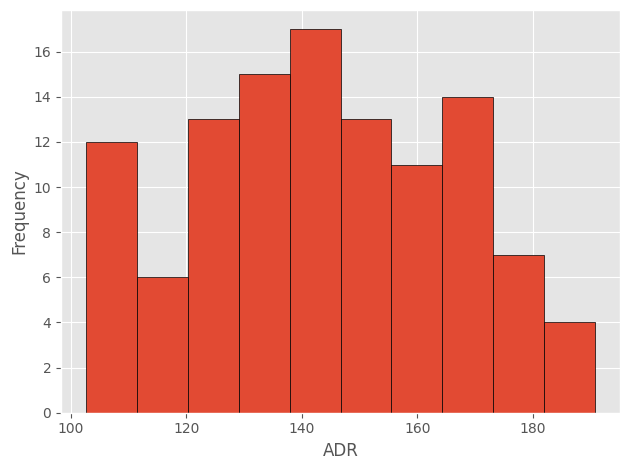

In [ ]:
# Гистограмма
data.adr.hist(edgecolor='black')
plt.xlabel('ADR')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Сравнение эмпирического распределения с теоретическим нормальным распределением

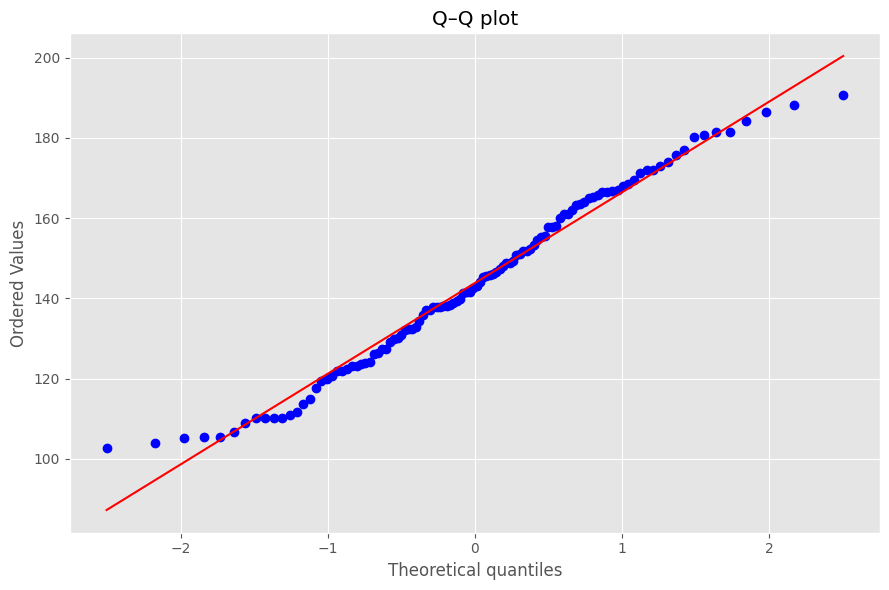

In [ ]:
plt.figure(figsize=(9, 6))
stats.probplot(data.adr, dist='norm', plot=plt)
plt.title('Q–Q plot')
plt.tight_layout()
plt.show()

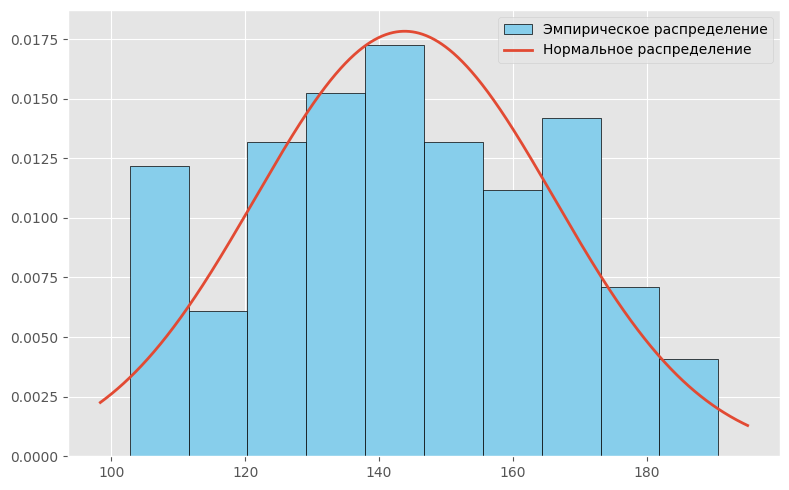

In [ ]:
log_x = data.adr
plt.figure(figsize=(8, 5))

# Построение гистограммы с плотностью
plt.hist(log_x, bins=10, density=True,
         color='skyblue', edgecolor='black', label='Эмпирическое распределение'
)

# Подгонка нормального распределения
mu, std = np.mean(log_x), np.std(log_x)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = stats.norm.pdf(x, mu, std)

# Наложение теоретической кривой
plt.plot(x, p, linewidth=2, label='Нормальное распределение')

plt.legend()
plt.tight_layout()
plt.show()

## Тест Шапиро–Уилка для проверки нормальности распределения

**Уровень значимости $\alpha = 0.05$**

**Нулевая гипотеза $H_0$**: данные распределены нормально

**Альтернативная гипотеза $H_1$**: данные НЕ распределены нормально

In [ ]:
p_value = stats.shapiro(data.adr)[1]
print(f'p-value: {p_value}')

p-value: 0.05428188056759172


> **Нулевая гипотеза** о нормальности распределения **не отвергается**. Визуальный анализ подтверждает, что возможные отклонения от нормальности являются незначительными.

# Критерий Стьюдента для независимых выборок

## Пример 1

`Данные` содержат возраст смерти европейцев середины XIX века, разделённых на три социальных класса:

* aris $-$ аристократия
* gent $-$ джентри (мелкое дворянство)
* sovr $-$ суверены (высшая знать, включая монархов)

Для каждого человека указан класс, возраст смерти и порядковый номер.

<br>

`Проверить` равенство средних возрастов смерти между аристократией (**aris**) и джентри (**gent**) при уровне значимости **$\alpha = 0.05$**.

Гипотезы:

- **Нулевая гипотеза $H_0$**: средние возрасты смерти в группах равны
- **Альтернативная гипотеза $H_1$**: средние различаются

In [ ]:
data = pd.read_csv('agedeath.dat.txt', sep=r'\s+', header=None, names=['group', 'age', 'index'])

In [ ]:
data[:3]

,group,age,index
0,aris,21,1
1,aris,21,2
2,aris,21,3


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6186 entries, 0 to 6185
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   group   6186 non-null   object
 1   age     6186 non-null   int64 
 2   index   6186 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 145.1+ KB


In [ ]:
# Описательные статистики для колонки "age"
data.age.describe().round(2)

,age
count,6186.00
mean,57.68
std,17.50
min,21.00
25%,45.00
50%,60.00
75%,71.00
max,102.00


In [ ]:
# Уникальные значения в колонке "group"
data.group.unique()

array(['aris', 'gent', 'sovr'], dtype=object)

In [ ]:
# Группы
x = data.loc[data.group == 'gent', 'age']
y = data.loc[data.group == 'aris', 'age']
x.name, y.name = 'gent', 'aris'

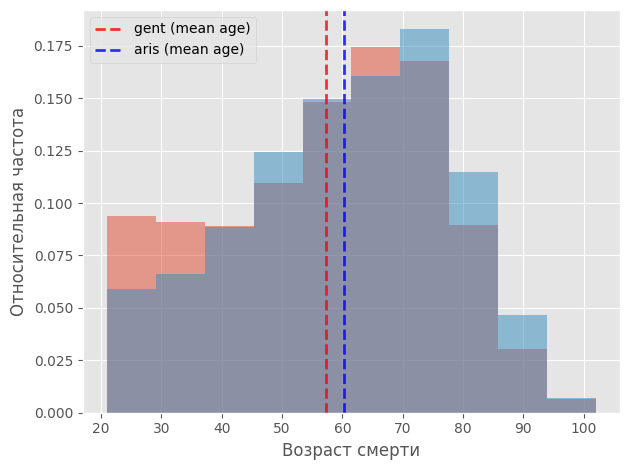

In [ ]:
# Визуализация распределений
x.hist(alpha=0.5, weights=[1./len(x)] * len(x))
y.hist(alpha=0.5, weights=[1./len(y)] * len(y))
plt.axvline(x.mean(), color='red', alpha=0.8, linestyle='dashed', linewidth=2)
plt.axvline(y.mean(), color='blue', alpha=0.8, linestyle='dashed', linewidth=2)
plt.legend([f'{x.name} (mean age)', f'{y.name} (mean age)'])
plt.xlabel('Возраст смерти')
plt.ylabel('Относительная частота')
plt.tight_layout()
plt.show()

> Данные существенных отклонений от нормальности не имеют.


<br>

Критерий **Флигнера–Килина** для проверки равенства дисперсий между двумя группами при **$\alpha = 0.05$**:

- **Нулевая гипотеза $H_0$**: дисперсии равны
- **Альтернативная гипотеза $H_1$**: дисперсии НЕ равны

In [ ]:
p_value = stats.fligner(x, y)[1]
print(f'p-value: {p_value}')

p-value: 0.07175470867996385


> Нулевая гипотеза НЕ отвергается.

<br>

Поскольку выборки состоят из разных объектов и не связаны между собой, они являются независимыми. Для проверки гипотезы о равенстве их средних значений следует использовать **двухвыборочный t-критерий Стьюдента** с предположением о равенстве дисперсий:

In [ ]:
p_value = stats.ttest_ind(x, y, equal_var=True, alternative='two-sided')[1]
print(f'p-value: {p_value}')

p-value: 1.4225217347727537e-08


> `Нулевая гипотеза` о равенстве средней продолжительности жизни аристократов и джентри `отвергается`. Это позволяет сделать вывод, что средняя продолжительность жизни аристократов статистически значимо выше, чем у джентри.

## Пример 2

Датасет содержит результаты 1000 студентов по трём предметам: *математике*, *чтению* и *письму* (баллы от 0 до 100).  
Также включены демографические и социально-экономические признаки:  
- пол
- этническая группа
- уровень образования родителей
- тип обеда
- прохождение подготовительного курса

In [ ]:
data = pd.read_csv('StudentsPerformance.csv')

In [ ]:
data[:3]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [ ]:
data.describe().round(2)

,math score,reading score,writing score
count,1000.00,1000.00,1000.00
mean,66.09,69.17,68.05
std,15.16,14.60,15.20
min,0.00,17.00,10.00
25%,57.00,59.00,57.75
50%,66.00,70.00,69.00
75%,77.00,79.00,79.00
max,100.00,100.00,100.00


In [ ]:
data.iloc[:, :-3].apply(
    lambda col: pd.Series({
        'unique_values': col.unique(),
        'n_unique': col.nunique()
    })
).T

,unique_values,n_unique
gender,"[female, male]",2
race/ethnicity,"[group B, group C, group A, group D, group E]",5
parental level of education,"[bachelor's degree, some college, master's degree, associate's degree, high school, some high school]",6
lunch,"[standard, free/reduced]",2
test preparation course,"[none, completed]",2


In [ ]:
agg_cols = ['math score', 'reading score', 'writing score']
data.groupby('test preparation course')[agg_cols].mean().round(1)

,math score,reading score,writing score
test preparation course,,,
completed,69.7,73.9,74.4
none,64.1,66.5,64.5


> `Влияет ли прохождение подготовительного курса (test preparation course) на итоговый балл студента?`

Формулировка гипотез:

- **Нулевая гипотеза $H_0$:** Средний итоговый балл у студентов, прошедших подготовительный курс, **не отличается** от балла тех, кто его не проходил.
- **Альтернативная гипотеза $H_1$:** Средний итоговый балл **отличается**.

Уровень значимости $\alpha = 0.05$

<br>

В анализе будет использована средняя оценка по трём предметам:

In [ ]:
data['avg_score'] = data[['math score', 'reading score', 'writing score']].mean(axis=1)

> Она обеспечивает сопоставимость с традиционными шкалами успеваемости и упрощает интерпретацию результатов.

In [ ]:
# Группы
completed = data.loc[data['test preparation course'] == 'completed', 'avg_score']
none = data.loc[data['test preparation course'] == 'none', 'avg_score']

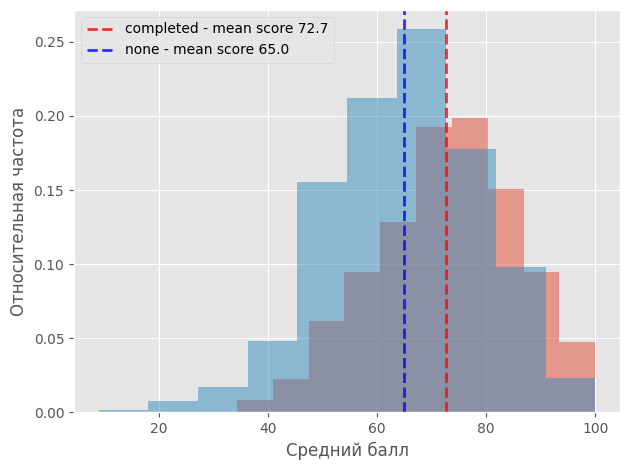

In [ ]:
# Визуализация распределений
completed.hist(alpha=0.5, weights=[1./len(completed)] * len(completed))
none.hist(alpha=0.5, weights=[1./len(none)] * len(none))
plt.axvline(completed.mean(), color='red', alpha=0.8, linestyle='dashed', linewidth=2)
plt.axvline(none.mean(), color='blue', alpha=0.8, linestyle='dashed', linewidth=2)
plt.legend([f'completed - mean score {completed.mean():.1f}', f'none - mean score {none.mean():.1f}'])
plt.xlabel('Средний балл')
plt.ylabel('Относительная частота')
plt.tight_layout()
plt.show()

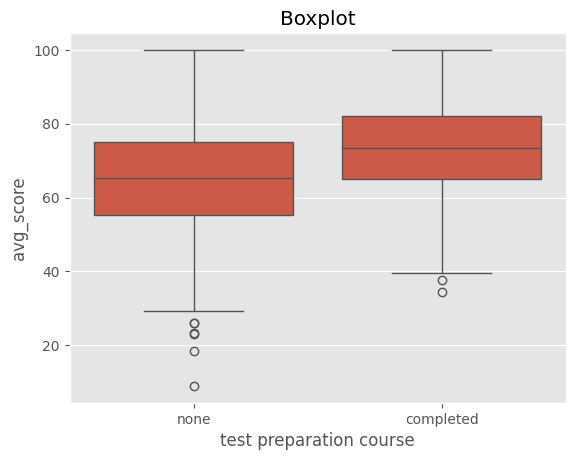

In [ ]:
# Ящики с усами
sns.boxplot(data=data, x='test preparation course', y='avg_score')
plt.title('Boxplot')
plt.show()

> В распределениях присутствуют `выбросы`, однако в остальном существенных отклонений от нормальности не наблюдается.

In [ ]:
# Выбросы
outlier_indices = []
grouped = data.groupby('test preparation course')['avg_score']

for group_name, group_data in grouped:
    Q1 = group_data.quantile(0.25)
    Q3 = group_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mask = (group_data < lower_bound) | (group_data > upper_bound)
    outlier_rows = group_data[mask].index.tolist()
    outlier_indices.extend(outlier_rows)

print(f'Индексы {len(outlier_indices)} строк с выбросами:')
print(outlier_indices)

Индексы 8 строк с выбросами:
[683, 842, 17, 59, 76, 327, 596, 980]


In [ ]:
data.iloc[outlier_indices]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,avg_score
683,female,group C,some high school,free/reduced,completed,29,40,44,37.666667
842,female,group B,high school,free/reduced,completed,23,44,36,34.333333
17,female,group B,some high school,free/reduced,none,18,32,28,26.000000
59,female,group C,some high school,free/reduced,none,0,17,10,9.000000
76,male,group E,some high school,standard,none,30,26,22,26.000000
327,male,group A,some college,free/reduced,none,28,23,19,23.333333
596,male,group B,high school,free/reduced,none,30,24,15,23.000000
980,female,group B,high school,free/reduced,none,8,24,23,18.333333


In [ ]:
# Удаление выбросов
completed = completed.drop(index=outlier_indices[:2])
none = none.drop(index=outlier_indices[2:])

Критерий **Флигнера–Килина** для проверки равенства дисперсий между двумя группами при **$\alpha = 0.05$**:

- **Нулевая гипотеза $H_0$**: дисперсии равны
- **Альтернативная гипотеза $H_1$**: дисперсии НЕ равны

In [ ]:
p_value = stats.fligner(completed, none)[1]
print(f'p-value: {p_value}')

p-value: 0.13832496737169184


> Нулевая гипотеза о равенстве дисперсий не отвергается.

<br>

Поскольку выборки состоят из разных объектов и не связаны между собой, они являются независимыми. Для проверки основной нулевой гипотезы следует использовать **двухвыборочный t-критерий Стьюдента** с предположением о равенстве дисперсий:

In [ ]:
p_value = stats.ttest_ind(completed, none, equal_var=True, alternative='two-sided')[1]
print(f'p-value: {p_value}')

p-value: 1.1869093906422294e-16


> Нулевая гипотеза $H_0$ **отклоняется**. Наличие подготовительного курса статистически значимо связано с более высокой успеваемостью.

<br>

На основе предварительного описательного анализа возникают содержательные вопросы, которые можно сформулировать в виде дополнительных статистических гипотез:

*1. Девочки демонстрируют более высокие результаты по чтению и письму, чем мальчики?*

In [ ]:
data.groupby('gender')[agg_cols].mean().round(1)

,math score,reading score,writing score
gender,,,
female,63.6,72.6,72.5
male,68.7,65.5,63.3


*2. Учащиеся с платным обедом показывают более высокие баллы?*

In [ ]:
data.groupby('lunch')[agg_cols].mean().round(1)

,math score,reading score,writing score
lunch,,,
free/reduced,58.9,64.7,63.0
standard,70.0,71.7,70.8


> Все перечисленные выше вопросы предполагают применение однотипных статистических процедур. В целях экономии места и избежания дублирования однородных вычислений мы ограничимся описательным сравнением средних значений, которое наглядно иллюстрирует наблюдаемые различия.

# Критерий Стьюдента для парных выборок

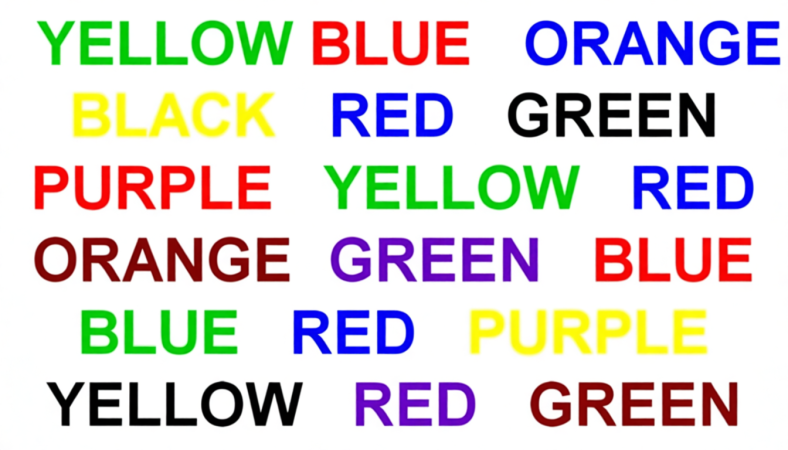

`Данные` представляют собой результаты эксперимента, основанного на парадигме Струпа, проведённого на 70 участниках (**Subj** = 1..70). Для каждого участника зафиксированы два значения времени реакции:

- **Black** $-$ время реакции в нейтральном условии, когда слово, обозначающее цвет, написано чёрным цветом (или без цветового конфликта).

- **DiffCol** $-$ время реакции, когда слово написано цветом, не соответствующим его значению.

<br>

`Проверить`, замедляет ли цветовой конфликт время реакции по сравнению с нейтральным условием. Уровень значимости **$\alpha = 0.05$**.

Гипотезы:

- **Нулевая гипотеза $H_0$**: среднее время реакции НЕ отличается
- **Альтернативная гипотеза $H_1$**: среднее время реакции отличается

In [ ]:
data = pd.read_csv('interference.csv')

In [ ]:
data[:3]

,Subj,DiffCol,Black
0,1,39.64,37.53
1,2,44.26,42.02
2,3,33.84,31.99


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Subj     70 non-null     int64  
 1   DiffCol  70 non-null     float64
 2   Black    70 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.8 KB


In [ ]:
# Описательные статистики
data.describe().round(2)

,Subj,DiffCol,Black
count,70.00,70.00,70.00
mean,35.50,43.30,41.00
std,20.35,6.15,4.84
min,1.00,29.13,29.85
25%,18.25,38.76,38.20
50%,35.50,44.33,40.96
75%,52.75,46.96,44.45
max,70.00,56.55,52.21


In [ ]:
# Группы
x, y = data['DiffCol'], data['Black']

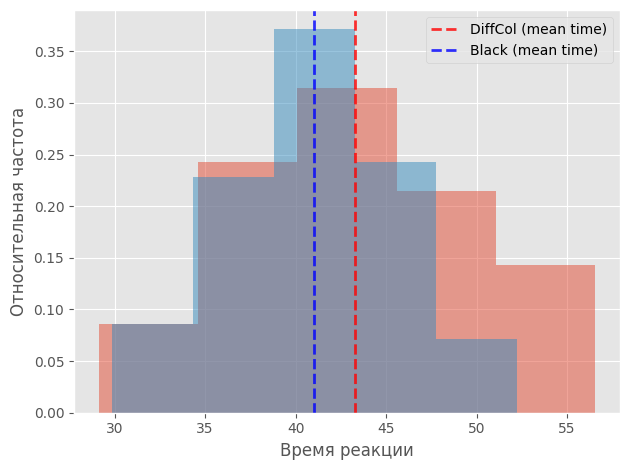

In [ ]:
# Визуализация распределений
x.hist(alpha=0.5, weights=[1./len(x)] * len(x), bins=5)
y.hist(alpha=0.5, weights=[1./len(y)] * len(y), bins=5)
plt.axvline(x.mean(), color='red', alpha=0.8, linestyle='dashed', linewidth=2)
plt.axvline(y.mean(), color='blue', alpha=0.8, linestyle='dashed', linewidth=2)
plt.legend([f'{x.name} (mean time)', f'{y.name} (mean time)'])
plt.xlabel('Время реакции')
plt.ylabel('Относительная частота')
plt.tight_layout()
plt.show()

> Данные существенных отклонений от нормальности не имеют.

<br>

Поскольку оба условия (`DiffCol` и `Black`) измерены на одних и тех же 70 участниках, наблюдения являются **зависимыми (парными)**. Следовательно, для проверки гипотезы о различии средних значений времени реакции в двух условиях следует использовать **парный t-критерий Стьюдента**:

In [ ]:
p_value = stats.ttest_rel(x, y)[1]
print(f'p-value: {p_value}')

p-value: 0.0162416779538072


`Нулевая гипотеза` о равенстве среднего времени реакции в условиях **DiffCol** и **Black** `отвергается`. Это свидетельствует о том, что среднее время реакции в инконгруэнтном условии статистически значимо выше, чем в нейтральном, что подтверждает наличие эффекта Струпа.

# Z-тесты для сравнения пропорций

В 2008-2012 годах **Рафаэль Надаль** демонстрировал выдающиеся результаты, особенно на грунтовых кортах, где его игра считается одной из самых доминирующих в истории тенниса. Ниже представлены данные о его победах и поражениях в этот период, разбитые по типу покрытия (грунт / не грунт) и по роли в геймах: подача и приём.

**Уровень значимости** на этот раздел: $\alpha = 0.05$

<br>

`Таблица 1.` Результаты Надаля на глиняных и других кортах

|        | WIN  | LOSS | TOTAL |
|--------|------|------|-------|
|Clay    | 1660 | 863  | 2523  |
|Nonclay | 3658 | 2715 | 6373  |
|Total   | 5318 | 3578 | 8896  |

<br>

**Общепринятое утверждение:** *"Надаль играет лучше на глине, чем на других покрытиях"*.

Формулировка гипотез:

- **Нулевая гипотеза $H_0$**: Надаль на глине играет не лучше.
- **Альтернативная гипотеза $H_1$**: Надаль выигрывает с бОльшей вероятностью на глиняных кортах.

In [ ]:
# Группа А (clay)
cw, ct = 1660, 2523  # число успехов, число испытаний

# Группа В (noclay)
nw, nt = 3658, 6373  # число успехов, число испытаний


print(
    f'Доля успехов (группа A):  {cw / ct:.4f}',
    f'Доля успехов (группа В):  {nw / nt:.4f}',
    sep='\n', end=2*'\n'
)


# Z-test для двух независимых пропорций
count = [cw, nw]
nobs = [ct, nt]
p_value = sm.stats.proportions_ztest(count, nobs, alternative='larger')[1]
print(f'p-value: {p_value}')

Доля успехов (группа A):  0.6579
Доля успехов (группа В):  0.5740

p-value: 1.6712477000327786e-13


> `alternative='larger':` "считай **p-value** как вероятность получить разницу пропорций **(p1 – p2)**, которая БОЛЬШЕ или РАВНА наблюдаемой, при условии, что на самом деле разницы нет."
>
> **Отвергаем нулевую гипотезу**. В период с 2008 по 2012 год доля побед Рафаэля Надаля на глиняных кортах была статистически значимо выше, чем на других покрытиях.

`Таблица 2.` Результаты Надаля на глиняных и других кортах $-$ геймы, в которых он подавал

|        | WIN  | LOSS | TOTAL |
|--------|------|------|-------|
|Clay    | 1090 | 171  | 1261  |
|Nonclay | 2747 | 446  | 3193  |
|Total   | 3837 | 617  | 4454  |

<br>

Формулировка гипотез:

- **Нулевая гипотеза $H_0$**: эффективность подачи одинакова на всех покрытиях.
- **Альтернативная гипотеза $H_1$**: эффективность отличается.

In [ ]:
# Группа А (clay)
cw, ct = 1090, 1261  # число успехов, число испытаний

# Группа В (noclay)
nw, nt = 2747, 3193  # число успехов, число испытаний


print(
    f'Доля успехов (группа A):  {cw / ct:.4f}',
    f'Доля успехов (группа В):  {nw / nt:.4f}',
    sep='\n', end=2*'\n'
)


# Z-test для двух независимых пропорций
count = [cw, nw]
nobs = [ct, nt]
p_value = sm.stats.proportions_ztest(count, nobs, alternative='two-sided')[1]
print(f'p-value: {p_value}')

Доля успехов (группа A):  0.8644
Доля успехов (группа В):  0.8603

p-value: 0.7229111916315871


> **Не отвергаем нулевую гипотезу**. Это логично: у топ-игроков доля выигранных геймов на подаче стабильно высока на всех покрытиях. Их преимущество на глине обычно проявляется на приёме, а не на подаче.

`Таблица 3.` Результаты Надаля на глиняных и других кортах $-$ геймы, в которых он принимал подачу

|        | WIN  | LOSS | TOTAL |
|--------|------|------|-------|
|Clay    | 570  | 692  | 1262  |
|Nonclay | 911  | 2269 | 3180  |
|Total   | 1481 | 2961 | 4442  |

<br>

Формулировка гипотез:

- **Нулевая гипотеза $H_0$**: Надаль не лучше принимает на глине, чем на других покрытиях.
- **Альтернативная гипотеза $H_1$**: Надаль лучше принимает на глине.

In [ ]:
# Группа А (clay)
cw, ct = 570, 1262  # число успехов, число испытаний

# Группа В (noclay)
nw, nt = 911, 3180  # число успехов, число испытаний


print(
    f'Доля успехов (группа A):  {cw / ct:.4f}',
    f'Доля успехов (группа В):  {nw / nt:.4f}',
    sep='\n', end=2*'\n'
)


# Z-test для двух независимых пропорций
count = [cw, nw]
nobs = [ct, nt]
p_value = sm.stats.proportions_ztest(count, nobs, alternative='larger')[1]
print(f'p-value: {p_value}')

Доля успехов (группа A):  0.4517
Доля успехов (группа В):  0.2865

p-value: 3.077044116944023e-26


> **Отвергаем нулевую гипотезу**. Есть очень сильные статистические доказательства, что приём Надаля значительно эффективнее на глине.